In [1]:
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR
from sklearn.preprocessing import StandardScaler

import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

### 1. Processing incidents data

Aggregate the incidents data into grids with side lengths of 500m and calculate the centroid of each grid. Calculate the response time of each event. The definition of response time here is reaction seconds plus driving seconds according to the requirements.

In [2]:
incidents = pd.read_csv('Data/WMFS_datasets/wmfs_incidents.csv')
# Only pay attention to incidents of type 'FIRE' and 'FALSE_ALARM'
incidents = incidents[incidents['incident_classification_level1'].isin(['FIRE', 'FALSE_ALARM'])]
incidents = incidents.reset_index(drop=True)

In [3]:
### Aggregate the data into grids
# Define the grid size
grid_size = 500

# Calculate the bound
xmin = incidents['EASTINGS'].min() // grid_size * grid_size # // means quotient rounding
xmax = incidents['EASTINGS'].max() // grid_size * grid_size + grid_size # rounding down so another grid needs to be added
ymin = incidents['NORTHINGS'].min() // grid_size * grid_size
ymax = incidents['NORTHINGS'].max() // grid_size * grid_size + grid_size
# Caculate the grid index
incidents['grid_x'] = ((incidents['EASTINGS'] - xmin) // grid_size).astype(int)
incidents['grid_y'] = ((incidents['NORTHINGS'] - ymin) // grid_size).astype(int)

# Add a grid_id to each incident and fire station
incidents['grid_id'] = incidents['grid_x'].astype(str) + "_" + incidents['grid_y'].astype(str)

In [4]:
### Caculate the centroid of each grid
incidents['centroid_x'] = xmin + (incidents['grid_x'] + 0.5) * grid_size
incidents['centroid_y'] = ymin + (incidents['grid_y'] + 0.5) * grid_size

# Extract the centroid coordinates into a new dataframe to facilitate merging later
grid_centroids = incidents[['grid_id', 'centroid_x', 'centroid_y']].drop_duplicates().reset_index(drop=True)
grid_centroids

,grid_id,centroid_x,centroid_y
0,12_29,392250.0,286750.0
1,39_11,405750.0,277750.0
2,48_33,410250.0,288750.0
3,21_54,396750.0,299250.0
4,49_36,410750.0,290250.0
...,...,...,...
3729,79_22,425750.0,283250.0
3730,68_8,420250.0,276250.0
3731,2_32,387250.0,288250.0
3732,69_9,420750.0,276750.0


In [5]:
# Define 'total response time'
incidents['total_response_time'] = incidents['reaction_seconds'] + incidents['driving_seconds']
incidents

,call_time,incident_classification_label,incident_profile_label,incident_classification_level1,prl_count,brv_count,EASTINGS,NORTHINGS,call_seconds,reaction_seconds,driving_seconds,grid_x,grid_y,grid_id,centroid_x,centroid_y,total_response_time
0,2009/1/1 0:00,False alarm raised with good intent,False Alarms,FALSE_ALARM,2,0,392062.1020,286844.9690,86,160,250,12,29,12_29,392250.0,286750.0,410
1,2009/1/1 0:10,Secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,1,0,405643.1494,277939.9802,85,65,239,39,11,39_11,405750.0,277750.0,304
2,2009/1/1 0:11,False alarm raised with malicious intent,False Alarms,FALSE_ALARM,1,0,410260.2444,288819.1894,62,106,115,48,33,48_33,410250.0,288750.0,221
3,2009/1/1 0:53,Secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,1,0,396779.2503,299030.1061,72,109,96,21,54,21_54,396750.0,299250.0,205
4,2009/1/1 0:52,False alarm raised with malicious intent,False Alarms,FALSE_ALARM,1,0,410667.9614,290492.4786,68,109,204,49,36,49_36,410750.0,290250.0,313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292692,2023/12/31 22:59,False Alarms (Equipment),Low Risk,FALSE_ALARM,2,0,398666.6867,283225.4570,88,82,281,25,22,25_22,398750.0,283250.0,363
292693,2023/12/31 23:11,False alarm raised with good intent,False Alarms,FALSE_ALARM,1,1,433136.8678,277909.0307,134,94,98,94,11,94_11,433250.0,277750.0,192
292694,2023/12/31 23:32,Accidental secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,0,1,401134.3304,277356.6820,136,152,227,30,10,30_10,401250.0,277250.0,379
292695,2023/12/31 23:49,False Alarms (Equipment),Low Risk,FALSE_ALARM,0,1,406221.0587,290654.1816,253,66,297,40,37,40_37,406250.0,290750.0,363


Then, calculate the proportion of delayed fires in each grid as the independent variable. The definition of delayed fire here is the historical incients with total response time greater than 300s.

In [6]:
grouped = incidents.groupby('grid_id')

# Create a list for each unique grid id
distribution = []

for name, group in grouped:
    # Count the fire incidents in each grid
    count = group.shape[0]
    
    # Calculate the count of incidents whose total_response_time > 300
    count_over_300 = group[group['total_response_time'] > 300].shape[0]
    
    # Calculate the proportion
    proportion_over_300 = count_over_300 / count if count > 0 else 0
    
    distribution.append([name, count, count_over_300, proportion_over_300])

grid = pd.DataFrame(distribution, columns=['grid_id','fire_count', 'count_over_300', 'proportion_over_300'])
grid

,grid_id,fire_count,count_over_300,proportion_over_300
0,0_51,1,1,1.000000
1,0_52,10,10,1.000000
2,0_53,4,4,1.000000
3,100_10,131,99,0.755725
4,100_11,103,48,0.466019
...,...,...,...,...
3729,9_59,27,27,1.000000
3730,9_60,42,37,0.880952
3731,9_61,63,60,0.952381
3732,9_62,59,55,0.932203


### 2. Processing the dependent variable and independent variables

First, isolate all independent variables (X) and the dependent variable (y) to be used.

In [7]:
# Load the feature data of grids and merge it with centroid coordinates
dataset = pd.read_csv('Data/dataset_no_land.csv')
dataset_coord = pd.merge(dataset, grid_centroids, on='grid_id', how='left')

In [8]:
# Load the land cover data and merge it with previous dataset
land_corine_1 = pd.read_csv('Data/land_cover/results/land_corine_1.csv') # corine land cover 1 2018

dataset_corine_1 = pd.merge(dataset_coord, land_corine_1, on='grid_id', how='left')

In [9]:
# Merge the dependent variable and independent variables
final_dataset = pd.merge(grid[['grid_id', 'proportion_over_300']], dataset_corine_1.drop(columns=['median', 'percentile_90']), on='grid_id', how='left')

In [10]:
final_dataset

,grid_id,proportion_over_300,"Accommodation, eating and drinking",Attractions,Commercial services,Education and health,Manufacturing and production,Public infrastructure,Retail,Sport and entertainment,...,road_length,nearest_station_distance,neighbour_frequency_per_month,station_count,centroid_x,centroid_y,Agricultural areas,Artificial surfaces,Forest and semi natural areas,Water bodies
0,0_51,1.000000,0,0,0,0,0,0,0,0,...,353.287313,3187.918600,0.177778,5,386250.0,297750.0,100.000000,0.000000,0.0,0.0
1,0_52,1.000000,0,0,0,1,0,1,0,1,...,1328.092389,2841.271722,0.194444,5,386250.0,298250.0,68.929306,31.070694,0.0,0.0
2,0_53,1.000000,0,1,0,1,1,1,0,0,...,768.983971,2546.139234,0.188889,5,386250.0,298750.0,56.548633,43.451367,0.0,0.0
3,100_10,0.755725,0,2,1,2,0,4,0,2,...,734.304719,1571.100570,5.922222,4,436250.0,277250.0,94.937310,5.062690,0.0,0.0
4,100_11,0.466019,0,1,3,0,0,1,0,1,...,2987.218972,1130.202194,3.855556,4,436250.0,277750.0,47.371040,52.628960,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729,9_59,1.000000,0,0,2,1,1,1,1,0,...,2006.875970,2561.426360,1.627778,6,390750.0,301750.0,0.000000,100.000000,0.0,0.0
3730,9_60,0.880952,0,0,13,2,2,3,2,1,...,2732.349447,2808.541436,2.211111,6,390750.0,302250.0,0.000000,100.000000,0.0,0.0
3731,9_61,0.952381,0,1,1,1,0,5,0,1,...,1543.196315,3116.874236,2.677778,6,390750.0,302750.0,0.000000,100.000000,0.0,0.0
3732,9_62,0.932203,3,1,4,0,0,5,1,3,...,2025.332899,3470.144810,2.005556,6,390750.0,303250.0,0.000000,100.000000,0.0,0.0


In [11]:
# Separate dependent and independt variables
X = final_dataset.drop(columns=['grid_id', 'proportion_over_300', 'centroid_x', 'centroid_y'])
y_delay = final_dataset['proportion_over_300']

#### Interpolation using similar grids

For grids with only 1, 2, and 3 historical data, their proportion of delyed fires data will make the model inaccurate. Use data from grids similar to them to interpolate.

In [12]:
# Drop the grids with incidents less than or equal to 3
grid_drop = grid[(grid['fire_count'] == 1) | (grid['fire_count'] == 2) | (grid['fire_count'] == 3)]
grid_drop_df = final_dataset[final_dataset['grid_id'].isin(grid_drop['grid_id'])]

In [13]:
# Caculate cosine similarity to find similar grids
def calculate_cosine_similarity(target_grid, all_grids, features_columns):
    target_vector = [target_grid[features_columns].values]
    all_vectors = all_grids[features_columns].values
    similarities = cosine_similarity(target_vector, all_vectors)
    return similarities.flatten()

In [14]:
# Interpolation
def interpolate_proportion(target_grid, similar_grids, num_similar=3):
    
    similar_grids_sorted = similar_grids.sort_values('similarity', ascending=False).head(num_similar)
    
    # Combine the original with the values of the similar grids
    combined_proportion = np.append(similar_grids_sorted['proportion_over_300'], target_grid['proportion_over_300'])
    
    # Calculate the average value
    average_proportion = combined_proportion.mean()
    
    return average_proportion

In [15]:
# Apply to grid_drop_df
def process_grid_interpolation(final_dataset, grid_drop_df, features_columns, num_similar=3):
    
    y_delay = final_dataset['proportion_over_300'].copy()

    for index, row in grid_drop_df.iterrows():
        
        similarities = calculate_cosine_similarity(row, final_dataset, features_columns)
        similar_grids = y_delay.copy()
        similar_grids = similar_grids.to_frame()

        similar_grids['similarity'] = similarities
        
        # Exclude the current grid itself
        similar_grids = similar_grids[similar_grids.index != index]
        
        # Exclude other grids with no sufficient data
        similar_grids = similar_grids.drop(grid_drop_df.index, errors='ignore')
        
        new_delay_proportion = interpolate_proportion(row, similar_grids, num_similar=num_similar)
        
        # Update y
        y_delay.at[index] = new_delay_proportion
    
    return y_delay

In [16]:
features_columns = X.columns.tolist()
y_delay = process_grid_interpolation(final_dataset, grid_drop_df, features_columns)

In [17]:
# Check how many grid's proportion of delayed fires values ​​changed due to interpolation
final_dataset_sorted = final_dataset.sort_index()
y_delay_sorted = y_delay.sort_index()

comparison = final_dataset_sorted['proportion_over_300'] != y_delay_sorted

comparison.sum()

195

### 3. Modelling

First, use random forest to select the 10 most important features. And then standardize the feature data to prevent matrix singularitiesand and perform geographically weighted regression.

#### Using Random Forest to select important featrures

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y_delay, test_size=0.2, random_state=0)

# Select the features using random forest
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

selector = SelectFromModel(rf, threshold='median')
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

In [19]:
# The value of feature importance
feature_importances = rf.feature_importances_
selected_features_mask = selector.get_support()

# Get the feature importance
selected_feature_importances = feature_importances[selected_features_mask]

selected_feature_indices = np.where(selected_features_mask)[0]
selected_feature_names = np.array(X.columns)[selected_feature_indices]

sorted_indices = np.argsort(selected_feature_importances)[::-1]

# Select the 10 most important features
top_10_features = selected_feature_names[sorted_indices][:10]
top_10_df = final_dataset[list(top_10_features)]

#### Geographically Weighted Regression

In [20]:
coords = dataset_coord[['centroid_x', 'centroid_y']].values

In [21]:
scaler = StandardScaler()
X_mgwr = top_10_df.values
X_mgwr_scaled = scaler.fit_transform(X_mgwr)

y_mgwr = y_delay.values.reshape(-1, 1)

# 看看能跑吗

In [22]:
# Choose the optimal bandwidth
gwr_selector = Sel_BW(coords, y_mgwr, X_mgwr_scaled)
optimal_bandwidth = gwr_selector.search()

In [23]:
optimal_bandwidth

1001.0

In [24]:
gwr_model = GWR(coords, y_mgwr, X_mgwr_scaled, optimal_bandwidth)
gwr_results = gwr_model.fit()

# 要这里输出的结果

In [25]:
print("R²:", gwr_results.R2)

local_coefficients = gwr_results.params
average_coefficients = np.mean(local_coefficients, axis=0)
print("mean coefficient of each x variable:", average_coefficients)

R²: 0.7285216738984959
mean coefficient of each x variable: [ 7.76849336e-01  2.19153620e-01 -4.94170886e-02  1.15004896e-03
  3.90661802e-02  5.04450378e-03  3.08374183e-03 -7.45925970e-04
 -2.08606822e-02 -8.27216493e-04  1.00041745e-02]


### 4. Plotting

# 图都要

In [26]:
local_r2 = gwr_results.localR2

# Create a geodataframe consisting of local R-squared, local coefficients of X1 and X2
data = pd.DataFrame({
    "X1_coeff": local_coefficients[:, 1], # coefficients of distance to the nearest fire station
    "X2_coeff": local_coefficients[:, 2], # coefficients of neighbourhood fire frequency
    "X4_coeff": local_coefficients[:, 4],
    "centroid_x": coords[:, 0], 
    "centroid_y": coords[:, 1],
    "R2_local": local_r2.flatten()
})

In [27]:
# Create the geometry column as Point objects
data['geometry'] = data.apply(lambda row: Point(row['centroid_x'], row['centroid_y']), axis=1)
gdf = gpd.GeoDataFrame(data, geometry='geometry', crs="EPSG:27700")

# Function to convert centroids to square polygons
def centroid_to_square(centroid, side_length=500):
    x, y = centroid.x, centroid.y
    half_side = side_length / 2
    return Polygon([
        (x - half_side, y - half_side),
        (x + half_side, y - half_side),
        (x + half_side, y + half_side),
        (x - half_side, y + half_side),
    ])

# Convert centroid points to square polygons
gdf['geometry'] = gdf['geometry'].apply(centroid_to_square)

#### Image of local R-squared

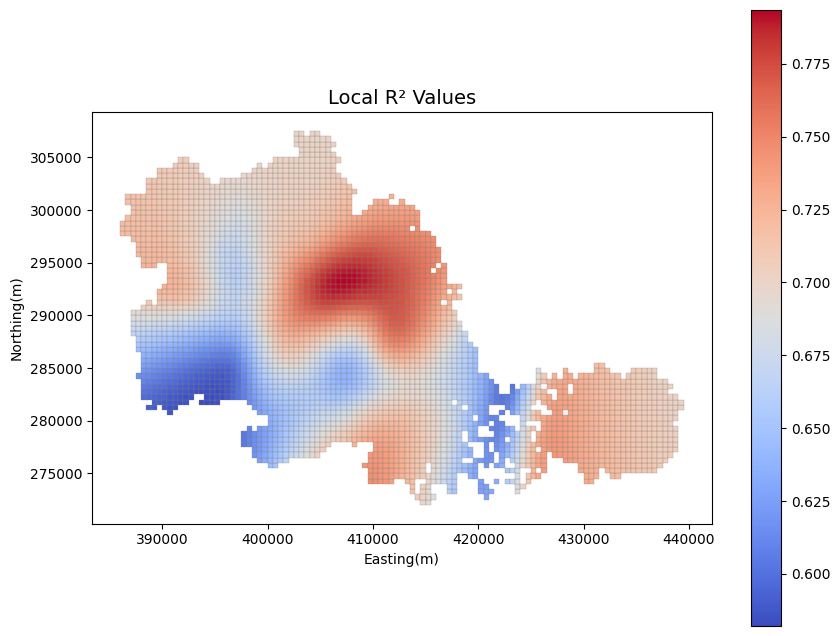

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='R2_local', cmap='coolwarm', legend=True, ax=ax, edgecolor='grey', linewidth=0.2)

ax.set_title("Local R² Values", fontsize=14)
plt.xlabel("Easting(m)")
plt.ylabel("Northing(m)")

plt.show()

#### Image of local coefficients

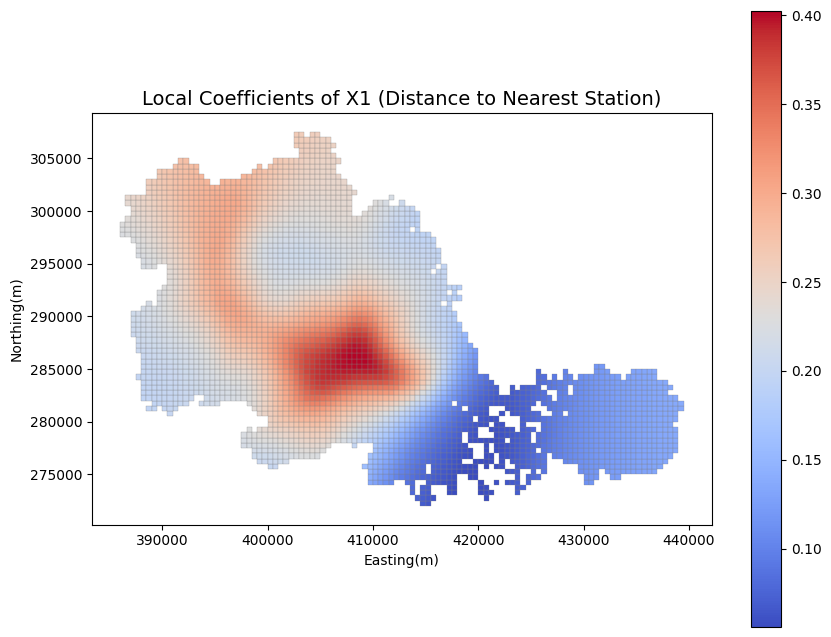

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='X1_coeff', cmap='coolwarm', legend=True, ax=ax, edgecolor='grey', linewidth=0.2)
ax.set_title("Local Coefficients of X1 (Distance to Nearest Station)", fontsize=14)
plt.xlabel("Easting(m)")
plt.ylabel("Northing(m)")

plt.show()

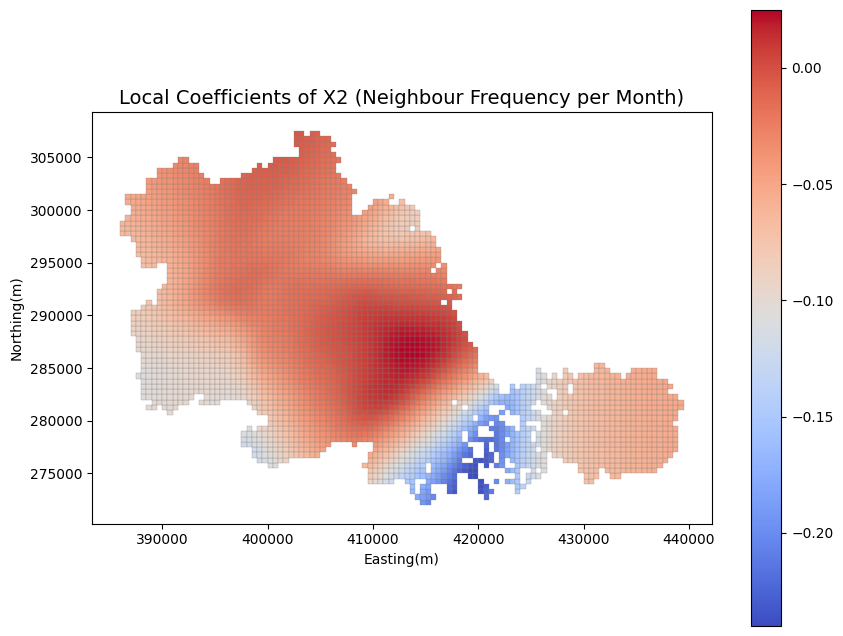

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='X2_coeff', cmap='coolwarm', legend=True, ax=ax, edgecolor='grey', linewidth=0.2)
ax.set_title("Local Coefficients of X2 (Neighbour Frequency per Month)", fontsize=14)
plt.xlabel("Easting(m)")
plt.ylabel("Northing(m)")

plt.show()

In [31]:
threshold = 0
gdf[gdf['X2_coeff'] > threshold].index

Index([1756, 1757, 1758, 1806, 1807, 1808, 1809, 1810, 1811, 1853,
       ...
       2919, 2948, 2949, 2950, 2951, 2952, 2953, 2977, 2978, 2979],
      dtype='int64', length=377)

# 看下面的图是不是只有一个点颜色不一样（不是的话没有必要往下运行了）

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='X4_coeff', cmap='coolwarm', legend=True, ax=ax, edgecolor='grey', linewidth=0.2)
ax.set_title("Local Coefficients of X4 (Stations Count))", fontsize=14)
plt.xlabel("Easting(m)")
plt.ylabel("Northing(m)")

plt.show()

In [35]:
from numpy.linalg import cond

# 小带宽：363 个点
small_bandwidth = 363
small_gwr_model = GWR(coords, y_mgwr, X_mgwr_scaled, bw=small_bandwidth, fixed=False)
small_gwr_results = small_gwr_model.fit()

# 大带宽：402 个点
large_bandwidth = 402
large_gwr_model = GWR(coords, y_mgwr, X_mgwr_scaled, bw=large_bandwidth, fixed=False)
large_gwr_results = large_gwr_model.fit()

# 计算每个点的局部条件数
small_conditions = []
large_conditions = []

for i in range(coords.shape[0]):
    small_weights = small_gwr_results.W[i]
    large_weights = large_gwr_results.W[i]
    
    # 局部特征矩阵（带权）
    small_local_X = X.values * small_weights[:, np.newaxis]
    large_local_X = X.values * large_weights[:, np.newaxis]
    
    try:
        small_conditions.append(cond(small_local_X))
        large_conditions.append(cond(large_local_X))
    except Exception:
        small_conditions.append(float('inf'))
        large_conditions.append(float('inf'))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=4.11552e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.9536e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=4.67825e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.74659e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: 

In [36]:
# large_conditions

[inf,
 inf,
 inf,
 9716.76771383052,
 9797.73477250953,
 9864.205015866766,
 10005.037314316927,
 10127.540897521634,
 10262.627402488395,
 10361.783714417388,
 10458.67905256294,
 10567.010992428464,
 10660.601781278487,
 10776.23216852412,
 10873.593299596152,
 11048.383839678792,
 11179.336615790493,
 11278.50054205947,
 11379.187623410768,
 9379.980557864697,
 9457.391973291053,
 9502.41622476102,
 9612.46840795315,
 9869.965196390604,
 9942.26624579267,
 10035.214501989773,
 10166.997902414798,
 10300.86785580252,
 10418.332150739272,
 10509.792459810904,
 10612.185390208262,
 10711.239458204362,
 10805.1934846068,
 10950.680227316281,
 11044.477785455725,
 11241.681688820026,
 11376.869319476818,
 11503.933904376348,
 11612.023639770829,
 9492.374418660995,
 9576.855212223461,
 9638.080357315743,
 9748.083391319218,
 9994.990839171207,
 10075.0665310178,
 10169.687516491673,
 10326.144581305116,
 10438.614447341468,
 10582.524638008636,
 10666.586667129164,
 10760.563786232875,
 

In [34]:
# dataset_coord.loc[79]


grid_id                                    104_13
median                                      287.0
percentile_90                               369.8
Accommodation, eating and drinking              1
Attractions                                     1
Commercial services                             7
Education and health                            1
Manufacturing and production                    1
Public infrastructure                           5
Retail                                          2
Sport and entertainment                         1
Transport                                       5
building_count                                537
total_rent                             109.118261
below_14                               233.812448
above_65                               190.481969
IMD                                     10.846973
node_count                                     59
connectivity                             1.186441
road_length                             4262.9995


In [157]:
# final_dataset.loc[79]


grid_id                                    104_13
proportion_over_300                      0.411765
Accommodation, eating and drinking              1
Attractions                                     1
Commercial services                             7
Education and health                            1
Manufacturing and production                    1
Public infrastructure                           5
Retail                                          2
Sport and entertainment                         1
Transport                                       5
building_count                                537
total_rent                             109.118261
below_14                               233.812448
above_65                               190.481969
IMD                                     10.846973
node_count                                     59
connectivity                             1.186441
road_length                             4262.9995
nearest_station_distance              1375.266156


In [37]:
final_dataset_drop = final_dataset.drop(final_dataset.index[79]).reset_index(drop=True)  # 删除第 79 行（从 0 开始计数）

dataset_coord_drop = dataset_coord.drop(dataset_coord.index[79]).reset_index(drop=True) 

In [38]:
X = final_dataset_drop.drop(columns=['grid_id', 'proportion_over_300', 'centroid_x', 'centroid_y'])
y_delay = final_dataset_drop['proportion_over_300']


In [39]:

#### Interpolation using similar grids
# Drop the grids with incidents less than or equal to 3
grid_drop = grid[(grid['fire_count'] == 1) | (grid['fire_count'] == 2) | (grid['fire_count'] == 3)]
grid_drop_df = final_dataset_drop[final_dataset_drop['grid_id'].isin(grid_drop['grid_id'])]
# Caculate cosine similarity to find similar grids
def calculate_cosine_similarity(target_grid, all_grids, features_columns):
    target_vector = [target_grid[features_columns].values]
    all_vectors = all_grids[features_columns].values
    similarities = cosine_similarity(target_vector, all_vectors)
    return similarities.flatten()
# Interpolation
def interpolate_proportion(target_grid, similar_grids, num_similar=3):
    
    similar_grids_sorted = similar_grids.sort_values('similarity', ascending=False).head(num_similar)
    
    # Combine the original with the values of the similar grids
    combined_proportion = np.append(similar_grids_sorted['proportion_over_300'], target_grid['proportion_over_300'])
    
    # Calculate the average value
    average_proportion = combined_proportion.mean()
    
    return average_proportion
# Apply to grid_drop_df
def process_grid_interpolation(final_dataset, grid_drop_df, features_columns, num_similar=3):
    
    y_delay = final_dataset['proportion_over_300'].copy()

    for index, row in grid_drop_df.iterrows():
        
        similarities = calculate_cosine_similarity(row, final_dataset, features_columns)
        similar_grids = y_delay.copy()
        similar_grids = similar_grids.to_frame()

        similar_grids['similarity'] = similarities
        
        # Exclude the current grid itself
        similar_grids = similar_grids[similar_grids.index != index]
        
        # Exclude other grids with no sufficient data
        similar_grids = similar_grids.drop(grid_drop_df.index, errors='ignore')
        
        new_delay_proportion = interpolate_proportion(row, similar_grids, num_similar=num_similar)
        
        # Update y
        y_delay.at[index] = new_delay_proportion
    
    return y_delay
features_columns = X.columns.tolist()
y_delay = process_grid_interpolation(final_dataset_drop, grid_drop_df, features_columns)


In [40]:

X_train, X_test, y_train, y_test = train_test_split(X, y_delay, test_size=0.2, random_state=0)

# Select the features using random forest
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

selector = SelectFromModel(rf, threshold='median')
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
# The value of feature importance
feature_importances = rf.feature_importances_
selected_features_mask = selector.get_support()

# Get the feature importance
selected_feature_importances = feature_importances[selected_features_mask]

selected_feature_indices = np.where(selected_features_mask)[0]
selected_feature_names = np.array(X.columns)[selected_feature_indices]

sorted_indices = np.argsort(selected_feature_importances)[::-1]

# Select the 10 most important features
top_10_features = selected_feature_names[sorted_indices][:10]
top_10_df = final_dataset_drop[list(top_10_features)]


In [41]:
coords = dataset_coord_drop[['centroid_x', 'centroid_y']].values


In [42]:
scaler = StandardScaler()
X_mgwr = top_10_df.values
X_mgwr_scaled = scaler.fit_transform(X_mgwr)

y_mgwr = y_delay.values.reshape(-1, 1)


# 1.

In [43]:
# Choose the optimal bandwidth
gwr_selector = Sel_BW(coords, y_mgwr, X_mgwr_scaled)
optimal_bandwidth = gwr_selector.search()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.94911e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=5.5749e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=6.68574e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=9.0911e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: I

LinAlgError: Matrix is singular.

In [71]:
# optimal_bandwidth

262.0

In [44]:
# optimal_bandwidth

402.0

In [44]:
X_0 = pd.read_csv('X.csv').iloc[:, 1:]
y_0 = pd.read_csv('y.csv').iloc[:, 1:]
coords_0 = pd.read_csv('coords.csv').iloc[:, 1:]

In [55]:
difference = y_0.values.reshape(-1, 1) - y_delay.values.reshape(-1, 1)
print(difference.max())

1.1102230246251565e-16


In [63]:
diff = X_0 - top_10_df
print("最大差异:", np.max(np.abs(diff)))

最大差异: 9.094947017729282e-13


In [54]:
top_10_df[~top_10_df.isin(X_0.to_dict(orient='list')).all(axis=1)]

,nearest_station_distance,neighbour_frequency_per_month,IMD,station_count,total_rent,above_65,connectivity,road_length,building_count,below_14
10,2152.058782,3.805556,21.321584,4,86.690039,223.825065,1.561404,4756.826813,500,292.524076
17,2537.996257,1.427778,26.943347,4,87.472205,23.479655,1.250000,1428.268952,18,58.635706
27,573.024432,4.738889,15.804258,4,130.632799,248.130321,1.384615,6253.440776,808,334.469457
31,2473.140716,5.683333,52.696309,4,253.221557,319.469686,1.395833,3943.724756,457,349.817980
42,1945.085345,7.316667,51.312608,4,335.827956,224.150419,1.318182,3954.452527,535,339.646821
...,...,...,...,...,...,...,...,...,...,...
3672,1923.111281,4.222222,23.294183,4,249.854713,269.881051,1.505495,6330.468656,971,429.051650
3679,1832.054857,3.505556,25.217046,4,129.803178,228.875909,1.318841,4776.666646,750,225.330300
3708,2174.753319,2.288889,21.212871,13,95.095982,181.534694,3.000000,1235.651939,194,102.391847
3727,2394.557370,2.166667,40.399156,8,109.098203,22.776086,3.000000,153.535335,32,42.720303


In [45]:
scaler = StandardScaler()
X_mgwr = X_0.values
X_mgwr_scaled = scaler.fit_transform(X_mgwr)

y_mgwr = y_0.values.reshape(-1, 1)

# 2.

In [46]:
# Choose the optimal bandwidth
gwr_selector = Sel_BW(coords, y_mgwr, X_mgwr_scaled)
optimal_bandwidth = gwr_selector.search()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.94911e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=5.5749e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=6.68574e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=9.0911e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: I

In [47]:
optimal_bandwidth

262.0

In [194]:
y_mgwr

array([[1.        ],
       [1.        ],
       [1.        ],
       ...,
       [0.95238095],
       [0.93220339],
       [1.        ]])

In [195]:
print("R²:", gwr_results.R2)

local_coefficients = gwr_results.params
average_coefficients = np.mean(local_coefficients, axis=0)
print("mean coefficient of each x variable:", average_coefficients)

R²: 0.8230498510625966
mean coefficient of each x variable: [-7.91919268e+11  2.58488270e-01 -5.72541428e-02 -8.93197152e-04
 -6.87534393e+11  5.68647559e-03 -5.82213609e-03 -6.27741322e-04
 -2.16408513e-02  9.97181666e-03  1.30464901e-02]


In [171]:
X = pd.read_csv('X.csv').iloc[:, 1:]

In [172]:
print(X.dtypes)
print(top_10_df.dtypes)

nearest_station_distance         float64
neighbour_frequency_per_month    float64
IMD                              float64
station_count                      int64
total_rent                       float64
above_65                         float64
connectivity                     float64
road_length                      float64
building_count                     int64
below_14                         float64
dtype: object
nearest_station_distance         float64
neighbour_frequency_per_month    float64
IMD                              float64
station_count                      int64
total_rent                       float64
above_65                         float64
connectivity                     float64
road_length                      float64
building_count                     int64
below_14                         float64
dtype: object


In [176]:
difference = X - top_10_df.reset_index(drop=True)
print(difference.max().max())  # 检查所有列中的最大差异

4.547473508864641e-13


In [ ]:
from numpy.linalg import cond

# 小带宽：363 个点
small_bandwidth = 366
small_gwr_model = GWR(coords, y_mgwr, X_mgwr_scaled, bw=small_bandwidth, fixed=False)
small_gwr_results = small_gwr_model.fit()

# 大带宽：402 个点
large_bandwidth = 402
large_gwr_model = GWR(coords, y_mgwr, X_mgwr_scaled, bw=large_bandwidth, fixed=False)
large_gwr_results = large_gwr_model.fit()

# 计算每个点的局部条件数
small_conditions = []
large_conditions = []

for i in range(coords.shape[0]):
    small_weights = small_gwr_results.W[i]
    large_weights = large_gwr_results.W[i]
    
    # 局部特征矩阵（带权）
    small_local_X = X.values * small_weights[:, np.newaxis]
    large_local_X = X.values * large_weights[:, np.newaxis]
    
    try:
        small_conditions.append(cond(small_local_X))
        large_conditions.append(cond(large_local_X))
    except Exception:
        small_conditions.append(float('inf'))
        large_conditions.append(float('inf'))

# 看这个图能不能画出来

import matplotlib.pyplot as plt
plt.hist(small_conditions, bins=30, alpha=0.5, label='Small Bandwidth (262 points)')
plt.hist(large_conditions, bins=30, alpha=0.5, label='Large Bandwidth (502 points)')
plt.xlabel("Condition Number")
plt.ylabel("Frequency")
plt.legend()
plt.title("Comparison of Condition Numbers: Small vs Large Bandwidth")
plt.show()